In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# CNN packages
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.utils import to_categorical
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dropout


Using TensorFlow backend.


In [5]:
# inputs
IMAGE_SIZE = 72 # IMAGE_SIZE*IMAGE_SIZE=nb of columns in dataset
batch = 32
epochs = 100 # parameter to test convergence

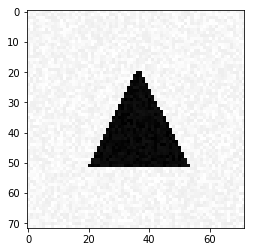

In [6]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')



def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

# import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# 3.Simple Classification

In order to classify images of rectangles, disks and triangles, images can contains noises or not, four layers with 128,62, 32 and 3 hidden units(neurons) are used in order to define the model. These fully connected layers are defined with Dense. I have chosen these features after several experiments, and concluded that this network is large enough to capture the structure of our dataset. 

The three first activation arguments are rectifier ("relu") and the last one is "softmax" for the last layer. A rectified linear unit has output 0 if the input is less than 0, and raw output otherwise. That is, if the input is greater than 0, the output is equal to the input. 

"Softmax" is chosen for the last layer because it is suitable for classification problems. Its output is equivalent to a categorical probability distribution. 

For the Compile model, our targets are one-hot encoded, so I set the <loss> parameter with "categorical_crossentropy". Here, the batch size, i.e. the number of samples that propagate through the network, is 32.
    
Since the catagory of our shapes is denoted with intergers 0,1,2, I have transformed them to 0 and 1 in a array in order to fit this model.

### Results

For both optimizers, stochastic gradient descent and ADAM, convergences are observed. ADAM converges much quicker and its accuracy (converges to 1) is much better than SGD method.

In [7]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
from keras.utils import np_utils
[X_test,Y_test] = generate_test_set_classification()

n_train=np.shape(X_train)[1]
n_test=np.shape(X_test)[1]


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [8]:
def Keras_model(n,optimizer):
    '''using Dense and compile to build CNN, input parameter <optimizer> equals to sgd or adam '''
    model = Sequential()
    model.add(Dense(128, input_dim=n, kernel_initializer='normal',activation='relu'))
    model.add(Dense(64, kernel_initializer='normal',activation='relu'))
    model.add(Dense(32, kernel_initializer='normal',activation='relu'))
    model.add(Dense(3,kernel_initializer='normal',activation='softmax'))
    # Compiling the CNN
    if optimizer == 'sgd':
        model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    
    return model

# SGD
The lower the loss, the better a model (unless the model has over-fitted to the training data). The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets.

In [22]:
Classifier_SGD = Keras_model(n_train,'sgd')

print('Summary of SGD Method')
print(Classifier_SGD)

#Train Model 
history = keras.callbacks.History()

# Convert labels to categorical one-hot encoding
ytrain_trinary = to_categorical(Y_train)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               663680    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 99        
Total params: 674,115
Trainable params: 674,115
Non-trainable params: 0
_________________________________________________________________
Summary of SGD Method


In [23]:
Classifier_SGD.fit(X_train,ytrain_trinary,epochs=epochs,batch_size =batch,callbacks=[history])

Epoch 1/100
300/300 [==============================] - 1s 2ms/step - loss: 1.0998 - acc: 0.3033
Epoch 2/100
300/300 [==============================] - 0s 500us/step - loss: 1.0948 - acc: 0.3733
Epoch 3/100
300/300 [==============================] - 0s 483us/step - loss: 1.0931 - acc: 0.3733
Epoch 4/100
300/300 [==============================] - 0s 506us/step - loss: 1.0919 - acc: 0.3700
Epoch 5/100
300/300 [==============================] - 0s 480us/step - loss: 1.0911 - acc: 0.3700
Epoch 6/100
300/300 [==============================] - 0s 450us/step - loss: 1.0903 - acc: 0.3700
Epoch 7/100
300/300 [==============================] - 0s 476us/step - loss: 1.0893 - acc: 0.3700
Epoch 8/100
300/300 [==============================] - 0s 486us/step - loss: 1.0887 - acc: 0.3700
Epoch 9/100
300/300 [==============================] - 0s 480us/step - loss: 1.0884 - acc: 0.3700
Epoch 10/100
300/300 [==============================] - 0s 486us/step - loss: 1.0878 - acc: 0.3700
Epoch 11/100
300/300 

300/300 [==============================] - 0s 493us/step - loss: 0.8607 - acc: 0.5800
Epoch 84/100
300/300 [==============================] - 0s 493us/step - loss: 0.7768 - acc: 0.6333
Epoch 85/100
300/300 [==============================] - 0s 526us/step - loss: 0.7825 - acc: 0.6133
Epoch 86/100
300/300 [==============================] - 0s 503us/step - loss: 0.8549 - acc: 0.5900
Epoch 87/100
300/300 [==============================] - 0s 500us/step - loss: 0.7490 - acc: 0.6467
Epoch 88/100
300/300 [==============================] - 0s 510us/step - loss: 0.7614 - acc: 0.6467
Epoch 89/100
300/300 [==============================] - 0s 500us/step - loss: 0.7597 - acc: 0.6233
Epoch 90/100
300/300 [==============================] - 0s 503us/step - loss: 0.7723 - acc: 0.6200
Epoch 91/100
300/300 [==============================] - 0s 490us/step - loss: 0.7584 - acc: 0.6400
Epoch 92/100
300/300 [==============================] - 0s 470us/step - loss: 0.7417 - acc: 0.6600
Epoch 93/100
300/300 [=

<function matplotlib.pyplot.show(*args, **kw)>

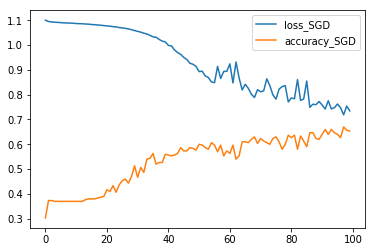

In [24]:
#Plot
loss_SGD = history.history.get('loss')
accuracy_SGD = history.history.get('acc')
plt.plot(loss_SGD)
plt.plot(accuracy_SGD)
plt.legend(['loss_SGD','accuracy_SGD'])
plt.show

# ADAM

In [12]:
Classifier_ADAM = Keras_model(n_train,'adam')
print('Summary of ADAM Method')
print(Classifier_ADAM)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               663680    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 674,115
Trainable params: 674,115
Non-trainable params: 0
_________________________________________________________________
Summary of ADAM Method


In [13]:
Classifier_ADAM.fit(X_train,ytrain_trinary,epochs=epochs,batch_size =batch,callbacks=[history])

Epoch 1/100
300/300 [==============================] - 1s 3ms/step - loss: 1.0951 - acc: 0.4100
Epoch 2/100
300/300 [==============================] - 0s 780us/step - loss: 1.0212 - acc: 0.6000
Epoch 3/100
300/300 [==============================] - 0s 830us/step - loss: 0.8579 - acc: 0.6233
Epoch 4/100
300/300 [==============================] - 0s 783us/step - loss: 0.6573 - acc: 0.6667
Epoch 5/100
300/300 [==============================] - 0s 816us/step - loss: 0.5054 - acc: 0.7300
Epoch 6/100
300/300 [==============================] - 0s 790us/step - loss: 0.4686 - acc: 0.7033
Epoch 7/100
300/300 [==============================] - 0s 793us/step - loss: 0.4437 - acc: 0.7633
Epoch 8/100
300/300 [==============================] - 0s 790us/step - loss: 0.4286 - acc: 0.7833
Epoch 9/100
300/300 [==============================] - 0s 820us/step - loss: 0.3993 - acc: 0.8133
Epoch 10/100
300/300 [==============================] - 0s 830us/step - loss: 0.4019 - acc: 0.8000
Epoch 11/100
300/300 

300/300 [==============================] - 0s 853us/step - loss: 2.9599e-05 - acc: 1.0000
Epoch 82/100
300/300 [==============================] - 0s 850us/step - loss: 2.8720e-05 - acc: 1.0000
Epoch 83/100
300/300 [==============================] - 0s 863us/step - loss: 2.7919e-05 - acc: 1.0000
Epoch 84/100
300/300 [==============================] - 0s 873us/step - loss: 2.7066e-05 - acc: 1.0000
Epoch 85/100
300/300 [==============================] - 0s 880us/step - loss: 2.6345e-05 - acc: 1.0000
Epoch 86/100
300/300 [==============================] - 0s 926us/step - loss: 2.5687e-05 - acc: 1.0000
Epoch 87/100
300/300 [==============================] - 0s 870us/step - loss: 2.4964e-05 - acc: 1.0000
Epoch 88/100
300/300 [==============================] - 0s 784us/step - loss: 2.4302e-05 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 0s 760us/step - loss: 2.3684e-05 - acc: 1.0000
Epoch 90/100
300/300 [==============================] - 0s 826us/step - loss: 2.3036e-

<function matplotlib.pyplot.show(*args, **kw)>

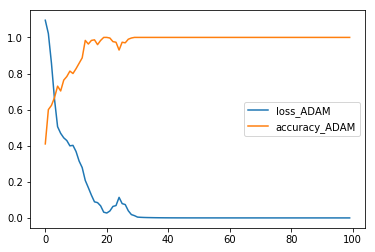

In [14]:
#Plot
loss_ADAM = history.history.get('loss')
accuracy_ADAM = history.history.get('acc')
plt.plot(loss_ADAM)
plt.plot(accuracy_ADAM)
plt.legend(['loss_ADAM','accuracy_ADAM'])
plt.show

# 4 Get Weights of each Layer


A Dense layer performs the following operation: h = Wx + b. The first output is the weight matrix W and the second output is the bias vector b. 

In [15]:
weight_SGD =Classifier_SGD.get_weights()[0]
weight_SGD.shape

(5184, 128)

In [16]:
weight_ADAM=Classifier_ADAM.get_weights()[0]
weight_ADAM.shape      

(5184, 128)

# 5 A More Difficult Classification Problem

This part aims at classifying shapes that locate randomly and change dimensions. metrics=['accuracy'] allows us to get the accuracy rate of the model in additional to the loss function. 

A 2D convolutional network is used on this new dataset. It is the input layer and has 16 feature maps, with the size of 5 * 5 and a rectifier activation function. Dataset needs to be reshaped to [samples][channels][width][height] in order to fit this model. Weigh and height equal to the root mean square of the shape of X. In the case of our data where the channels values are gray scale, the pixel dimension is set to 1.

After the step of Pooling, I employed a regularization layer using dropout. It is configured torandomly exclude 20% of neurons in the layer in order to reduce overfitting. Flatten allows the output to be processed by standard fully connected layers. The last step is to build fully connected layers, whose structure is similiar to previous classification problem.

### Results
The accuray of the model is 78%. Convergence is reach around 60 epochs. Numerical results are satisfying, but the model is very time consuming. It remains to be improved.


In [17]:
# Generate data with random position
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
[X_test, Y_test] = generate_test_set_classification() 


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [25]:
# reshape to be [samples][channels][width][height]
X_train_4D = X_train.reshape(X_train.shape[0],IMAGE_SIZE, IMAGE_SIZE ,1).astype('float32')
X_test_4D = X_test.reshape(X_test.shape[0],IMAGE_SIZE, IMAGE_SIZE ,1).astype('float32')

# one hot encode outputs
Y_train_trinary = to_categorical(Y_train)
Y_test_trinary = to_categorical(Y_test)

In [26]:
def baseline_model(n):
    '''Using Convolution2D,MaxPooling2D,Dropout and Dense to build CCN, the parameter <optimizer> is choosen and equal to adam '''
    # Initialising the CNN
    classifier = Sequential()

    # Step - 1 Convolution
    #The layer has 16 feature maps, with the size of 5 * 5 and a rectifier activation function. This is the input layer.
    classifier.add(Convolution2D(16, 5, 5, input_shape=(72, 72, 1), activation='relu'))

    # Step - 2 Pooling
    classifier.add(MaxPooling2D(pool_size=(2, 2)))

    classifier.add(Convolution2D(32, 3, 3, activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Dropout: regularization layer using dropout. It is configured torandomly exclude 20% of neurons in the layer in order to reduce overfitting.
    classifier.add(Dropout(0.2))

    # Step - 3 Flattening
    #Flatten. It allows the output to be processed by standard fully connected layers.
    classifier.add(Flatten())

    # Step - 4 Full connection -> First layer input layer then hidden layer
    # and last softmax layer
    #a fully connected layer with 128 neurons and rectifier activation function is used.
    classifier.add(Dense(128, input_dim=n, kernel_initializer='normal',activation='relu'))
    classifier.add(Dense(64, kernel_initializer='normal',activation='relu'))
    classifier.add(Dense(32, kernel_initializer='normal',activation='relu'))
    classifier.add(Dense(3,kernel_initializer='normal',activation='softmax'))


    # Compiling the CNN
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

In [27]:
# build the model
model = baseline_model(n_train)
# Fit the model
model.fit(X_train_4D, Y_train_trinary, validation_data=(X_test_4D, Y_test), epochs=epochs, batch_size=batch,verbose=2)



Train on 300 samples, validate on 300 samples
Epoch 1/100
 - 11s - loss: 1.0992 - acc: 0.3433 - val_loss: 1.1015 - val_acc: 0.3300
Epoch 2/100
 - 10s - loss: 1.0884 - acc: 0.3700 - val_loss: 1.0946 - val_acc: 0.3333
Epoch 3/100
 - 8s - loss: 1.0763 - acc: 0.4200 - val_loss: 1.0724 - val_acc: 0.5600
Epoch 4/100
 - 9s - loss: 1.0166 - acc: 0.5633 - val_loss: 0.9929 - val_acc: 0.5200
Epoch 5/100
 - 9s - loss: 0.8873 - acc: 0.6000 - val_loss: 0.8254 - val_acc: 0.5933
Epoch 6/100
 - 9s - loss: 0.7651 - acc: 0.6267 - val_loss: 0.7746 - val_acc: 0.6367
Epoch 7/100
 - 9s - loss: 0.7637 - acc: 0.6467 - val_loss: 0.8056 - val_acc: 0.5833
Epoch 8/100
 - 9s - loss: 0.6661 - acc: 0.6633 - val_loss: 0.7474 - val_acc: 0.6433
Epoch 9/100
 - 9s - loss: 0.5827 - acc: 0.7400 - val_loss: 0.8776 - val_acc: 0.6533
Epoch 10/100
 - 9s - loss: 0.6262 - acc: 0.7233 - val_loss: 0.7046 - val_acc: 0.7267
Epoch 11/100
 - 9s - loss: 0.5656 - acc: 0.7800 - val_loss: 0.7148 - val_acc: 0.6933
Epoch 12/100
 - 9s - loss:

Epoch 95/100
 - 10s - loss: 0.0012 - acc: 1.0000 - val_loss: 1.5864 - val_acc: 0.7767
Epoch 96/100
 - 9s - loss: 0.0029 - acc: 1.0000 - val_loss: 1.6906 - val_acc: 0.7733
Epoch 97/100
 - 9s - loss: 0.0029 - acc: 1.0000 - val_loss: 1.4540 - val_acc: 0.7767
Epoch 98/100
 - 9s - loss: 0.0034 - acc: 1.0000 - val_loss: 1.4337 - val_acc: 0.7733
Epoch 99/100
 - 9s - loss: 0.0094 - acc: 0.9967 - val_loss: 1.7219 - val_acc: 0.7700
Epoch 100/100
 - 9s - loss: 0.0097 - acc: 0.9967 - val_loss: 1.5456 - val_acc: 0.7800


<function matplotlib.pyplot.show(*args, **kw)>

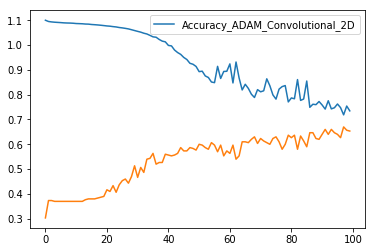

In [28]:
#Plot
loss_ADAM_Conv = history.history.get('loss')
accuracy_ADAM_Conv = history.history.get('acc')
plt.plot(loss_ADAM_Conv)
plt.legend(['loss_ADAM_Convolutional_2D'])
plt.show
plt.plot(accuracy_ADAM_Conv)
plt.legend(['Accuracy_ADAM_Convolutional_2D'])
plt.show

In [29]:
# Final evaluation of the model
#.evaluate() computes the loss based on the input you pass it, along with any other metrics that you requested in the metrics param when you compiled your model 
scores = model.evaluate(X_test_4D, Y_test)
print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Accuracy: %.2f%%" % (scores[1]*100))
print("CNN Loss: %.2f" % (scores[0]))

300/300 [==============================] - 1s 3ms/step
CNN Error: 22.00%
CNN Accuracy: 78.00%
CNN Loss: 1.55


# 6 A Regression Problem
This part focus on prediction the location of the vertices of a triangle, given an image of this triangle. Images contain noises.

I have normalized both inputs and outputs in order to get values between 0 and 1. My experiements show that convolutional networks don't help to improve accuracy, so I decide to employ fully connected layers to tackle this problem.

A triangle can be identified with three points. In our dataset, the shape of Y_train is (300,6). Each simulation contains 6 values, which are [X(0),Y(0),X(1),Y(1),X(2),Y(2)]. The objectif is to predict these 6 values of each triangle.

### Results
The value of loss function is very small, the model seams to perform well. But differences between each data point [X(i),Y(i)] is too small. For this reason, the shape of predicted triangle is very small comparing to inputs. Another difficulty is that the shape of triangle is not very clear, and the presence of noise make the object location much more difficult.

When the triangle's surface is big enough, the prediction located inside the input triangle. However, then the triangle shape is not clear, prediction result is poor.

One possible reason for this error is that the model fail to realize that, each data point of a triangle is interchangeable. 

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


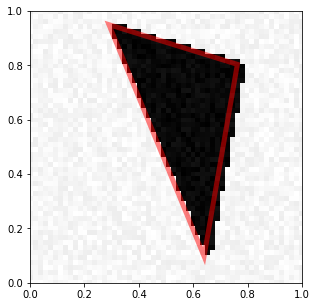

In [70]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
[X_test, Y_test] = generate_test_set_regression()
visualize_prediction(X_train[0], Y_train[0])

In [31]:
X_train_norm =(X_train - np.mean(X_train)) / np.std(X_train)
X_test_norm =(X_test - np.mean(X_test)) / np.std(X_test)

In [32]:
# Normalize x, y by img_size, so that all values are between 0 and 1.
Y_train_norm = Y_train.reshape(Y_train.shape[0], -1) / IMAGE_SIZE
Y_test_norm = Y_test.reshape(Y_test.shape[0], -1) / IMAGE_SIZE
Y_test_norm.shape, np.mean(Y_test_norm), np.std(Y_test_norm)

((300, 6), 0.00690625371749478, 0.004011789596324513)

In [51]:
model = Sequential()
model.add(Dense(128, input_dim=X_train_norm.shape[-1], kernel_initializer='normal',activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='normal',activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(32, kernel_initializer='normal',activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(3,kernel_initializer='normal',activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(Y_train_norm.shape[-1]))
model.compile(optimizer='adadelta', loss='mse')

In [52]:
model.fit(X_train_norm, Y_train_norm, validation_data=(X_test_norm, Y_test_norm), epochs=20, batch_size=batch,verbose=2,callbacks=[history])

Train on 300 samples, validate on 300 samples
Epoch 1/20
 - 1s - loss: 3.1758e-04 - val_loss: 5.1457e-05
Epoch 2/20
 - 0s - loss: 4.3910e-05 - val_loss: 3.0322e-05
Epoch 3/20
 - 0s - loss: 2.8727e-05 - val_loss: 2.4237e-05
Epoch 4/20
 - 0s - loss: 2.3435e-05 - val_loss: 2.2052e-05
Epoch 5/20
 - 0s - loss: 2.1132e-05 - val_loss: 2.0779e-05
Epoch 6/20
 - 0s - loss: 1.9802e-05 - val_loss: 1.9989e-05
Epoch 7/20
 - 0s - loss: 1.8908e-05 - val_loss: 1.9546e-05
Epoch 8/20
 - 0s - loss: 1.8316e-05 - val_loss: 1.8912e-05
Epoch 9/20
 - 0s - loss: 1.7895e-05 - val_loss: 1.8706e-05
Epoch 10/20
 - 0s - loss: 1.7523e-05 - val_loss: 1.8620e-05
Epoch 11/20
 - 0s - loss: 1.7289e-05 - val_loss: 1.8154e-05
Epoch 12/20
 - 0s - loss: 1.7043e-05 - val_loss: 1.7944e-05
Epoch 13/20
 - 0s - loss: 1.6904e-05 - val_loss: 1.7720e-05
Epoch 14/20
 - 0s - loss: 1.6761e-05 - val_loss: 1.7585e-05
Epoch 15/20
 - 0s - loss: 1.6712e-05 - val_loss: 1.7578e-05
Epoch 16/20
 - 0s - loss: 1.6503e-05 - val_loss: 1.7688e-05
Epo

<function matplotlib.pyplot.show(*args, **kw)>

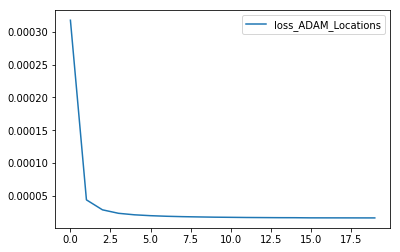

In [53]:
loss_ADAM_locations = history.history.get('loss')

plt.plot(loss_ADAM_locations)
plt.legend(['loss_ADAM_Locations'])
plt.show

In [54]:
# Predict bounding boxes on the test images.
pred_Y = model.predict(X_test_norm)
pred_triangles = pred_Y * IMAGE_SIZE

In [55]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

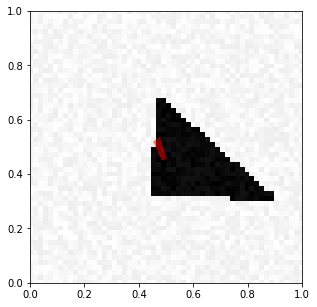

array([0.44416567, 0.33037206, 0.45311888, 0.67686012, 0.87141638,
       0.30311524])

array([0.46406004, 0.51678896, 0.47262794, 0.52290094, 0.49349755,
       0.45442414], dtype=float32)

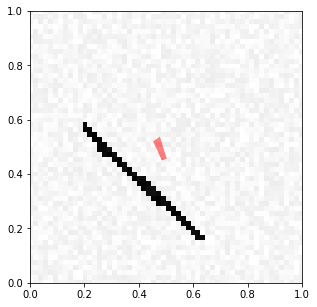

array([0.62208022, 0.14731968, 0.25730081, 0.48896147, 0.18250246,
       0.57415514])

array([0.46406004, 0.51678896, 0.47262794, 0.52290094, 0.49349755,
       0.45442414], dtype=float32)

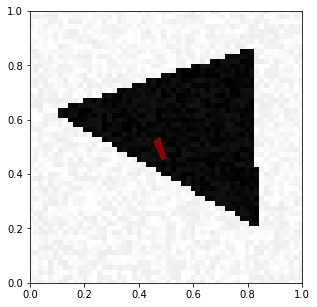

array([0.79051217, 0.8570231 , 0.81355856, 0.21326272, 0.09218341,
       0.62794772])

array([0.46406004, 0.51678896, 0.47262794, 0.52290094, 0.49349755,
       0.45442414], dtype=float32)

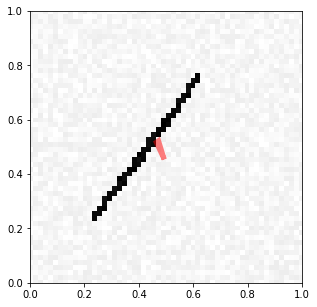

array([0.61134504, 0.77155581, 0.21487756, 0.22677233, 0.39666126,
       0.45811595])

array([0.46406004, 0.51678896, 0.47262794, 0.52290094, 0.49349755,
       0.45442414], dtype=float32)

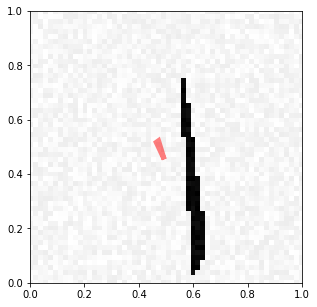

array([0.6246601 , 0.13500592, 0.58837558, 0.02786487, 0.5433922 ,
       0.73977445])

array([0.46406004, 0.51678896, 0.47262794, 0.52290094, 0.49349755,
       0.45442414], dtype=float32)

In [69]:
# 18,54,73,82

triangles =[18,82,156,254,288]
for i in triangles:
    visualize_prediction(X_test[i],pred_triangles[i])
    display(Y_test[i])
    display(pred_triangles[i])


# 7. Denoising

In this part, I have modified the generate_a_* function on order to have it returned images with and without noise. The denoising procedure should be donne with encoder and decoder.

In [71]:
def generate_a_rectangle_bis(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    im_rectangle=generate_a_drawing(figsize, U, V, noise)
    im_rectangle_no_noise=generate_a_drawing(figsize, U, V, 0.0)
    
    return [im_rectangle,im_rectangle_no_noise]

def generate_a_disk_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    im_disk= generate_a_drawing(figsize, U, V, noise)
    im_dis_no_noise=generate_a_drawing(figsize, U, V, 0.0)
    return [im_disk,im_dis_no_noise]

def generate_a_triangle_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)

    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)

        
    imdata = generate_a_drawing(figsize, U, V, noise)
    imdata_no_noise= generate_a_drawing(figsize, U, V, 0.0)
    return [[imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]],[imdata_no_noise, [U[0], V[0], U[1], V[1], U[2], V[2]]]]

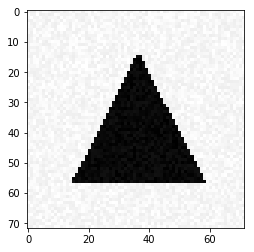

In [72]:
[[im_triangle,v],[im_triangle_no_noise,v]]= generate_a_triangle_bis(20, False)
display(plt.imshow(im_triangle.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray'))

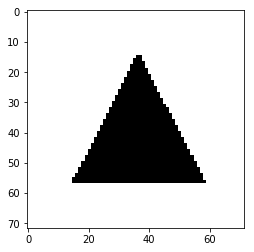

In [73]:
plt.imshow(im_triangle_no_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

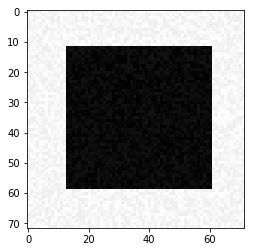

In [74]:
[im_rectangle,im_rectangle_no_noise]= generate_a_rectangle_bis(20, False)
plt.imshow(im_rectangle.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


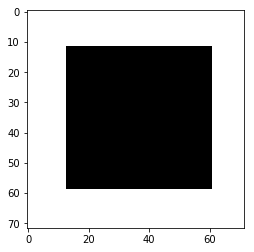

In [75]:
plt.imshow(im_rectangle_no_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

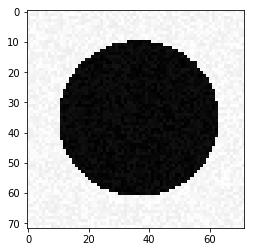

In [76]:
[im_disk,im_disk_no_noise]= generate_a_disk_bis(20, False)
plt.imshow(im_disk.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

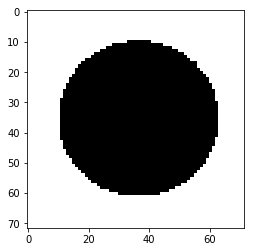

In [77]:
plt.imshow(im_disk_no_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [78]:
def generate_dataset_classification_bis(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_no_noise = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i],X_no_noise[i]] = generate_a_rectangle_bis(noise, free_location)
        elif category == 1: 
            [X[i],X_no_noise[i]] = generate_a_disk_bis(noise, free_location)
        else:
            [[X[i], V],[X_no_noise[i], V_no_noise]] = generate_a_triangle_bis(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    X_no_noise = X/255
    return [[X, Y],[X_no_noise,Y]]

def generate_test_set_classification_bis():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification_bis(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [79]:
[[X_train,Y_train],[X_train_noise,Y_train]] = generate_dataset_classification_bis(300,20,True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
